# MAPS calculation 

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

## Color and plotting style

In [2]:
# Choose style sheet(s)
plt.style.use("file:../scripts_plots/plot_styles/default.mplstyle")

# Import functions from the _color_tools notebook
%run ../scripts_plots/_color_tools.ipynb

# Assign the color palette to a variable.
# Individual colors can be selected by index (e.g. C[0])
C = sns.color_palette().as_hex()
sns.color_palette()

[(0.0, 0.4666666666666667, 0.7333333333333333),
 (0.0, 0.6, 0.5333333333333333),
 (0.9333333333333333, 0.4666666666666667, 0.2),
 (0.8, 0.2, 0.06666666666666667),
 (0.2, 0.7333333333333333, 0.9333333333333333),
 (0.9333333333333333, 0.2, 0.4666666666666667),
 (0.7333333333333333, 0.7333333333333333, 0.7333333333333333),
 (0.0, 0.0, 0.0)]

## Load data

In [3]:
syn = pd.read_csv(
    "../outputs/proportion_singletons_synonymous_by_context.tsv", sep="\t"
)

## Plot the proportion of singletons vs mutability

In [4]:
x = syn["mu"]
y = syn["ps"]

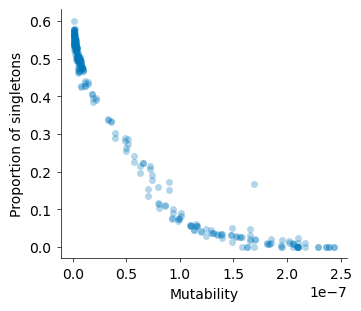

In [5]:
def plot_ps_vs_mu(x, y):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), layout="constrained")

    ax.scatter(x, y, alpha=0.3, linewidths=0)
    ax.set_xlabel("Mutability")
    ax.set_ylabel("Proportion of singletons")

    return fig, ax


plot_ps_vs_mu(x, y)

plt.savefig("../plots/proportion_singletons_synonymous_vs_mu.svg", format="svg")

There appears to be a log-linear relationship here.

## Log transformation

/home/alex/miniconda3/ukb/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<Figure size 350x300 with 1 Axes>,
 <Axes: xlabel='Mutability', ylabel='Proportion of singletons'>)

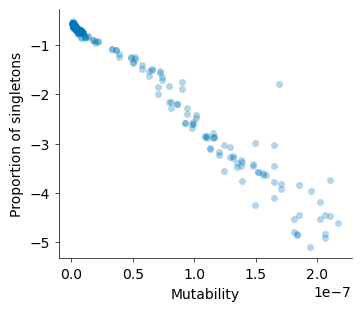

In [6]:
plot_ps_vs_mu(x, np.log(y))

The relationship is nearly linear after log transformation of the proportion of singletons. Note that some context have ps == 0. 

## Model proportion of singletons vs mutability 

In [11]:
# Drop sites with no singletons
_syn = syn[syn["ps"] != 0]

#
x1 = _syn["mu"]
X1 = sm.tools.add_constant(x1)
y1 = _syn["ps"]
w1 = _syn["n_obs"]

model = sm.WLS(np.log(y1), X1, weights=w1).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.993
Model:                            WLS   Adj. R-squared:                  0.993
No. Observations:                 282   F-statistic:                 3.850e+04
Covariance Type:            nonrobust   Prob (F-statistic):          7.58e-302
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5734      0.004   -127.722      0.000      -0.582      -0.565
mu         -2.096e+07   1.07e+05   -196.209      0.000   -2.12e+07   -2.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is a strong and highly significant correlation. How does it look visually?

Text(0.2, 0.2, '$R^2$ = 0.993')

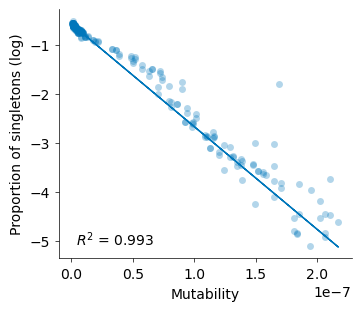

In [12]:
fig, ax = plot_ps_vs_mu(x1, np.log(y1))
ax.set_ylabel("Proportion of singletons (log)")

# Plot the regression line
Y1 = model.predict(X1)
ax.plot(x1, Y1)
fig.text(x=0.2, y=0.2, s=rf"$R^2$ = {model.rsquared:.3f}")

There is a nice linear fit. How well does it hold for non-CpG sites?

(<Figure size 350x300 with 1 Axes>,
 <Axes: xlabel='Mutability', ylabel='Proportion of singletons (log)'>)

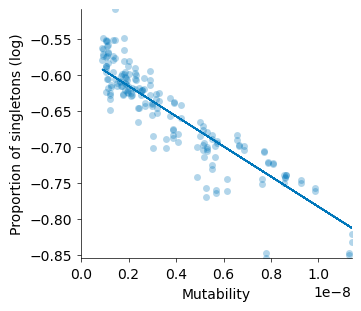

In [17]:
non_cpg = _syn[_syn["variant_type"] != "CpG"]

x2 = non_cpg["mu"]
X2 = sm.tools.add_constant(x2)
y2 = non_cpg["ps"]
w2 = non_cpg["n_obs"]

fig, ax = plot_ps_vs_mu(x2, np.log(y2))
ax.set_ylabel("Proportion of singletons (log)")
ax.set_xlim(0, x2.max())
ax.set_ylim(np.log(y2).min(), np.log(y2).max())

# Plot the regression line
ax.plot(x1, Y1)

It holds fairly well for non-CpG contexts as well. What does a model based on non-CpG sites only look like?

In [21]:
model2 = sm.WLS(np.log(y2), X2, weights=w2).fit()
model2.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.786
Model:                            WLS   Adj. R-squared:                  0.784
No. Observations:                 176   F-statistic:                     637.3
Covariance Type:            nonrobust   Prob (F-statistic):           4.59e-60
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5830      0.005   -112.447      0.000      -0.593      -0.573
mu         -1.987e+07   7.87e+05    -25.245      0.000   -2.14e+07   -1.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

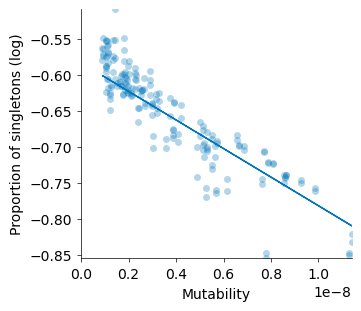

In [22]:
Y2 = model2.predict(X2)

fig, ax = plot_ps_vs_mu(x2, np.log(y2))
ax.set_ylabel("Proportion of singletons (log)")
ax.set_xlim(0, x2.max())
ax.set_ylim(np.log(y2).min(), np.log(y2).max())

# Plot the regression line
ax.plot(x2, Y2)

The plot looks nearly identical.

## Summary statistics

In [23]:
# This text file contains statistics for both CpG and non-CpG sites
df = pd.read_csv("../outputs/proportion_singletons_by_csq_and_region_no_cpg.tsv", sep="\t")

df["csq"] = pd.Categorical(
    df["csq"],
    categories=[
        "synonymous",
        "missense",
        "nonsense",
        "nmd_target",
        "long_exon",
        "distal_nmd",
        "start_proximal",
    ],
)

df = df.sort_values("csq")

df["se"] = np.sqrt((df["ps"] * (1 - df["ps"])) / df["n_obs"])
df["ps_pred"] = np.exp(model.predict(sm.tools.add_constant(df["mu"])))
df["maps"] = np.round((df["ps"] - df["ps_pred"]), 3)
df["ci95"] = 1.96 * df["se"]

df.to_csv(
    "../outputs/proportion_singletons_maps_summary_statistics.tsv",
    sep="\t",
    index=False,
)

df

,csq,mu,n_singletons,n_obs,ps,se,ps_pred,maps,ci95
2,synonymous,5.987558e-09,1395327,2810047,0.496549,0.000298,0.497113,-0.001,0.000585
0,missense,5.019917e-09,3297481,6201057,0.531761,0.000200,0.507299,0.024,0.000393
1,nonsense,4.957895e-09,117416,192416,0.610220,0.001112,0.507959,0.102,0.002179
5,nmd_target,5.003376e-09,69208,111290,0.621871,0.001454,0.507475,0.114,0.002849
4,long_exon,4.798374e-09,7895,12338,0.639893,0.004322,0.509661,0.130,0.008470
3,distal_nmd,4.823988e-09,29094,49500,0.587758,0.002212,0.509387,0.078,0.004336
6,start_proximal,5.141169e-09,11219,19288,0.581657,0.003552,0.506012,0.076,0.006962


In [24]:
# Read text file for all contexts
df_all = pd.read_csv("../outputs/proportion_singletons_by_csq_and_region_cpg.tsv", sep="\t")

# Read text file for non-CpG contexts 
df_non_cpg = pd.read_csv("../outputs/proportion_singletons_by_csq_and_region_no_cpg.tsv", sep="\t")

